# EEG analysis - Neuro Science 2022
### Full analysis of digit experiment - 
#### Cluster Based Permutation testing and T-test
This script contains the workflow of EEG statistical testing of the Neuro Science Digit Experiment using Cluster Based Permutation testing and T-testing.


#### Introduction of Experiment
In this experiment we will investigate the predictive processing of the brain using EEG.

The experiment will consist of 2 different phases:

In phase 1, the participants will throughout 30 rounds be presented to a sequence of numbers containing 5 digits (e.g. 1,2,3,4,5). The participant is instructed to memorise the sequence of numbers in that specific order of the sequence.

In phase 2, the participant will again be shown 5 numbers in a sequence displayed on at a time throughout 90 trials. These new sequences of numbers are either manipulated in the beginning or in the end of the sequence (e.g. 1,8,3,4,5 or 1,2,3,8,5 ), or are similar to the first memorised sequence. Thus, we have 30 trials of sequences of 5 digits with a manipulation in the beginning (e.g 1,8,3,4,5), 30 trials of sequences of 5 digits with a manipulation in the end of the sequence (1,2,3,8,5 ), and 30 trials similar to the memorised sequence in phase 1 (1,2,3,4,5). The participant is instructed to report whether the sequences of numbers in phase 2 are equal to or different from the memorised sequence from phase 1 (1,2,3,4,5) as soon as they experience the sequence being different or equal.

When measuring the neural signals using EEG, we generally expect to see a spike of activity when each number is read. Moreover, we expect to see a greater spike of activity in the visual cortex when the sequence of numbers are manipulated in the beginning(1,8,3,4,5 ), and to see an even greater spike of activity in the visual cortex when the sequence of numbers are manipulated in the end (1,2,3,8,5 ).

We expect to see increased activity in visual cortex when the one number in the sequence deviates from the anticipation of the participant, this being an anticipation we induced in the participant in phase 1. Thus, the participant expects to see the memorised sequence of numbers, and then experiences a moment of “surprise” when seeing a number that does not fit in the memorised sequence, and this will be evident in the EEG measures.

In [17]:
%%capture

# importing modules
import os
import pip
os.system('python -m pip install mne')
os.system('python -m pip install scikit-learn')
import numpy as np
!pip install pandas
from pandas import *
import mne
from scipy import stats as st
import statistics as stats
from itertools import combinations
import matplotlib.pyplot as plt
import mne
import random

!python -m pip install statsmodels
from statsmodels.stats.multitest import multipletests as multi

## Read data (epochs saved from previous analysis)

In [18]:
# read the epochs
epochs = mne.read_epochs('/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif')

# extracting the epochs we need (i.e wrong 3rd place, wrong 5th place, correct)
incorr_2 = epochs['recog_phase/incorr2/second']
incorr_4 = epochs['recog_phase/incorr4/fourth']
correct = epochs['recog_phase/corr/fifth'] ### AT FIFTH to have an equal amount of elements, justify more???


# creating evoked for incorrect 3rd place
incorr_2_evoked = incorr_2.average()

# creating evoked for incorrect 5th place
incorr_4_evoked = incorr_4.average()

#  creating evoked for correct
correct_evoked = correct.average()


# Merging the 3 evokeds together
all_evokeds = dict(incorr2=incorr_2_evoked, incorr4= incorr_4_evoked, correct = correct_evoked)

#set seed
random.seed(1)

Reading /work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
523 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_192/1892190047.py:2: RuntimeWarning: This filename (/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif')


## Windowed Mean
We've got 3 conditions of interest: 
- trials with incorrect digit in 2nd place
- trials with incorrect digit in 4th place 

One of the simplest way in which we can determine whether the signal in our conditions are statistically significant is by:

Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature.
Taking the mean of that window across channels and trials and samples.
Running statistical tests on the windowed means from the two conditions.
In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant, we can keep one dimension of the individual data, i.e. the trials.

## T-Test
In this analysis, we will perform 3 t-tests to establish whether the means of the two groups are statistically significant. One on Incorrect 2 and Correct trials, another on Incorrect 4 and Correct trials, and lastly a t-test on Incorrect 2nd place trials and Incorrect 4th place trials. 

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.


In [19]:
incor2_data = incorr_2.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)
print(incor2_data.shape)

incor4_data = incorr_4.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)
print(incor4_data.shape)

corr_data = correct.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)
print(corr_data.shape)

(25, 2, 25)
(26, 2, 25)
(31, 2, 25)


/tmp/ipykernel_192/279760880.py:1: RuntimeWarning: Channel(s) ['T6', 'T5'] could not be picked, because they are not present in the info instance.
  incor2_data = incorr_2.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)
/tmp/ipykernel_192/279760880.py:4: RuntimeWarning: Channel(s) ['T6', 'T5'] could not be picked, because they are not present in the info instance.
  incor4_data = incorr_4.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)
/tmp/ipykernel_192/279760880.py:7: RuntimeWarning: Channel(s) ['T6', 'T5'] could not be picked, because they are not present in the info instance.
  corr_data = correct.get_data(picks=['Oz', 'Pz', 'T6', 'T5'], tmin=.1, tmax=.2)


Now we can average over the data so we only have the trials dimension.

In [6]:
incor2_mean = np.mean(incor2_data, axis=2) # averaging over the third dimension of the data
incor2_mean = np.mean(incor2_mean, axis=1) # averaging over the second dimension of the data

incor4_mean = np.mean(incor4_data, axis=2)
incor4_mean = np.mean(incor4_mean, axis=1)

corr_mean = np.mean(corr_data, axis=2)
corr_mean = np.mean(corr_mean, axis=1)

In [7]:
from scipy import stats as st
import statistics as stats

#T -test on incorrect 2 and incorrect 4
st.ttest_ind(a=incor2_mean, b=incor4_mean)

Ttest_indResult(statistic=-0.07600870366320843, pvalue=0.9397216682114321)

In [8]:
#T -test on incorrect 4 and correct
st.ttest_ind(a=incor4_mean, b=corr_mean)

Ttest_indResult(statistic=1.049192342053317, pvalue=0.29867818172128213)

In [9]:
#T -test on incorrect 2 and correct
st.ttest_ind(a=incor2_mean, b=corr_mean)

Ttest_indResult(statistic=0.9554388414409489, pvalue=0.3436136504205546)

# Cluster based Permutation

## 1. Set threshold for t-values (contrast) for clustering
H0: there is no diffference in neural activity between seeing an incorrect digit at place 2 and place 4 in the sequence. 


In [10]:
# getting the data from incorr 2nd, incorr 4th and correct condition
X = [epochs[k].get_data() for k in ['recog_phase/incorr2/second', 'recog_phase/incorr4/second', 'recog_phase/corr/fifth']]
print(X[0].shape)

# transposing
X = [np.transpose(x, (0, 2, 1)) for x in X]
print(X[0].shape)

(25, 30, 175)
(25, 175, 30)


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


Text(0.5, 1.0, 'Between-sensor adjacency')

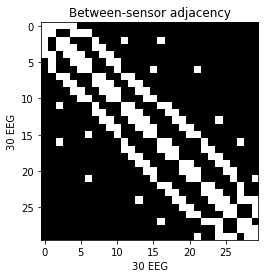

In [11]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [12]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 1
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=2000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=1)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 3.113792
stat_fun(H1): min=0.000151 max=13.230335
Running initial clustering
Found 54 clusters
Permuting 1999 times...


/tmp/ipykernel_192/2478297223.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=2000, tail=0,


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [23]:
print(p_values)
print(good_cluster_inds)

[9.775e-01 1.000e+00 4.760e-01 1.000e+00 1.000e+00 4.100e-01 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 9.995e-01 9.910e-01 1.000e+00 1.000e+00
 9.995e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.910e-01 3.510e-01
 6.020e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 5.585e-01
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.600e-01
 2.850e-01 5.000e-04 9.340e-01 1.000e+00 1.000e+00 9.905e-01 1.000e+00
 1.000e+00 9.995e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 4.150e-01 1.000e+00 1.000e+00 1.000e+00]
[36]


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


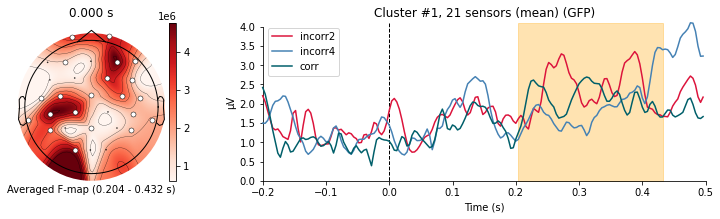

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
colors = {"incorr2": "crimson", "incorr4": 'steelblue', "corr": "#005f6a"}

# organising data for plotting
evokeds = {cond: epochs[cond].average() for cond in ["recog_phase/incorr2/second", "recog_phase/incorr4/fourth", "recog_phase/corr/fifth"]} 

# looping over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpacking cluster information
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # getting signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # creating spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialising the figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plotting average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # creating additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # adding axes for colourbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # adding new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plotting temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean-up
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()

STATISTICAL SIGNIFICANT DIFFERENECE IN THE YELLOW WINDOW,between the 3 conditions.  This cluster is based on 19 and 6 sensors out of the 30 sensors.

## 1.1 Incorr2 and Incorr4

stat_fun(H1): min=0.000151 max=13.230335
Running initial clustering
Found 48 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
combining channels using "gfp"
combining channels using "gfp"


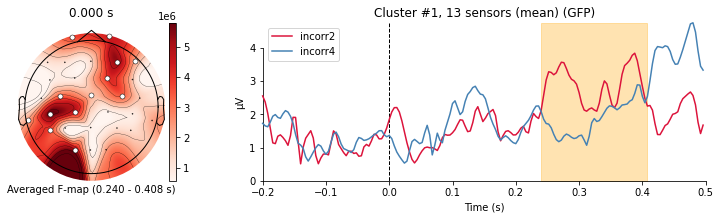

In [14]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=2000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4, threshold = 4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
colors = {"incorr2": "crimson", "incorr4": 'steelblue'}

# organising data for plotting
evokeds = {cond: epochs[cond].average() for cond in ["recog_phase/incorr2/second", "recog_phase/incorr4/fourth"]} 


# looping over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpacking cluster information
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # getting signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # creating spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialising the figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plotting average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # creating additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # adding axes for colourbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # adding new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plotting temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean-up
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()

## Extracting data into CSV file
For further analysis and plotting in R.


In [26]:
## csv for incorr 2
shape = incor2_data.shape
index = MultiIndex.from_product([range(s)for s in shape])
incor2_1 = DataFrame({'incorr2_data': incor2_data.flatten()}, index=index).reset_index()
incor2_1.to_csv('incorr2_data.csv', index=False)

## csv for incorr 4
shape = incor4_data.shape
index = MultiIndex.from_product([range(s)for s in shape])
incor4_1 = DataFrame({'incorr4_data': incor4_data .flatten()}, index=index).reset_index()
incor4_1.to_csv('incorr4_data.csv', index=False)

## csv for correct
shape = corr_data.shape
index = MultiIndex.from_product([range(s)for s in shape])
corr_1 = DataFrame({'correct_data': corr_data .flatten()}, index=index).reset_index()
corr_1.to_csv('correct_data.csv', index=False)


## 2. Compare conditions
Get t-valuesfor the contrast (for the difference in the two conditions) for each time-stamp

## 3. Form cluster out of t-values for the contrast 
Form cluster out of t-values for the contrast (difference in two conditions) that go
beyond the threshold. Sum the t-values of that particular cluster together with all
the neighbouring channels (to get the space dimension). Do this for all the data

## 4. Take the highest t-value sum among all the clusters you identify. 
Save this number.

## 5. PERMUTATION: Shuffle the two conditions i.e., making an empirical null distribution

## 6. Repeat step 2-4 for the new distribution (data that was shuffled).
Recommended to repeat this step 10,000 times. Save the highest t-value sums of the clusters for each run (i.e., you will end up with 10,000 highest t-value sums)

## 7. Make a distribution of the 10,000 highest t-value sums

## 8.  If the initial highest t-value (from step 4) is outside the distribution (larger or smaller) then you say that you have a significant difference between the two conditions